In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.mlemodel import MLEModel
from statsmodels.tsa.statespace.dynamic_factor import DynamicFactor
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
from statsmodels.tsa.statespace.mlemodel import MLEModel
from statsmodels.tsa.stattools import adfuller
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor, callback

In [2]:
# Laste poll-of-polls data
url = "https://raw.githubusercontent.com/jensmorten/onesixtynine/main/data/pollofpolls_master.csv"
df = pd.read_csv(url)

In [3]:
# Convert to datetime and set the date to the end of the month
df["Mnd"] = pd.to_datetime(df["Mnd"])

In [4]:
# Sort values and set index
df = df.sort_values("Mnd")
df.set_index("Mnd", inplace=True)
df.index.to_period('M').to_timestamp('M')

DatetimeIndex(['2008-01-31', '2008-02-29', '2008-03-31', '2008-04-30',
               '2008-05-31', '2008-06-30', '2008-07-31', '2008-08-31',
               '2008-09-30', '2008-10-31',
               ...
               '2025-01-31', '2025-02-28', '2025-03-31', '2025-04-30',
               '2025-05-31', '2025-06-30', '2025-07-31', '2025-08-31',
               '2025-09-30', '2025-10-31'],
              dtype='datetime64[ns]', name='Mnd', length=214, freq='ME')

In [5]:
print(df.index[-5:])  # check last few dates

DatetimeIndex(['2025-06-30', '2025-07-31', '2025-08-31', '2025-09-30',
               '2025-10-31'],
              dtype='datetime64[ns]', name='Mnd', freq=None)


In [6]:
df=df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]
df.dropna(inplace=True)

In [18]:
def hybrid_var_ml_forecast(df, n_months, var_lags, lags_ML):
    model = VAR(df)
    var_res = model.fit(maxlags=var_lags, method="ols", trend="n")

    mean_var, lower_var, upper_var = var_res.forecast_interval(
        var_res.endog, steps=n_months
    )

    fitted = var_res.fittedvalues
    true = df.iloc[var_res.k_ar:]
    resid = true.values - fitted.values

    X, y = [], []
    for i in range(lags_ML, len(df)):
        if i - var_res.k_ar < 0:
            continue
        X.append(df.iloc[i-lags_ML:i].values.flatten())
        y.append(resid[i - var_res.k_ar])

    X = np.asarray(X)
    y = np.asarray(y)

    n_parties = df.shape[1]
    ml_resid_forecast = np.zeros((n_months, n_parties))

    if len(X) < 100:
        return mean_var, lower_var, upper_var

    for j in range(n_parties):
        yj = y[:, j]

        model_ml = LGBMRegressor(
            n_estimators=500,
            num_leaves=16,
            learning_rate=0.01,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=123,
            verbose=-1
        )
        model_ml.fit(X, yj)

        win = df.values[-lags_ML:].copy()

        for t in range(n_months):
            r = model_ml.predict(win.reshape(1, -1))[0]
            ml_resid_forecast[t, j] = r
            win = np.vstack([win[1:], mean_var[t]])

    forecast = mean_var + ml_resid_forecast
    return forecast, lower_var + ml_resid_forecast, upper_var + ml_resid_forecast


In [19]:
forecast_df, forecast_lower_df, forecast_upper_df = hybrid_var_xgb_with_var_intervals(
    df,
    n_months=12,
    var_lags=6,
    lags_ML=6
)

C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


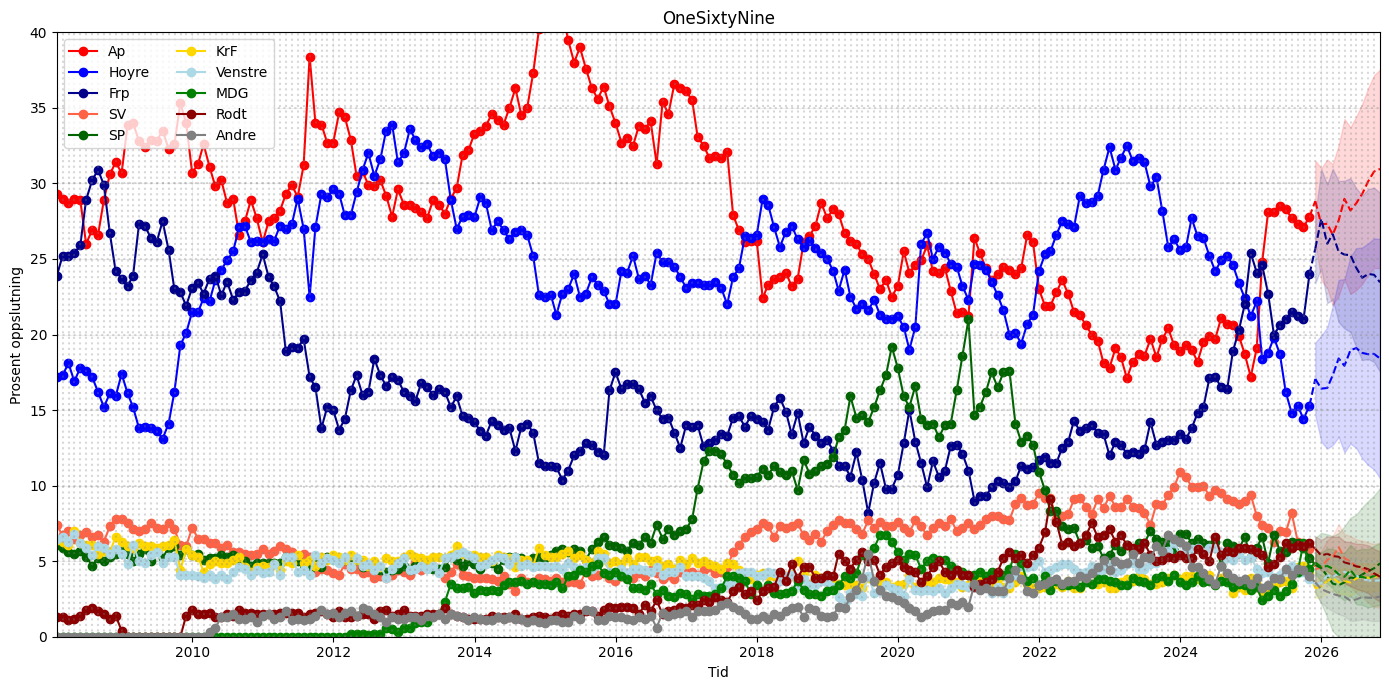

In [23]:
# --- Define colors for consistency ---
colors = {
    'Ap': '#FF0000',        # Red
    'Hoyre': '#0000FF',     # Blue
    'Frp': '#00008B',       # Dark Blue
    'SV': '#FF6347',        # Light Red (Tomato)
    'SP': '#006400',        # Dark Green
    'KrF': '#FFD700',       # Yellow (Gold)
    'Venstre': '#ADD8E6',   # Light Blue
    'MDG': '#008000',       # Green
    'Rodt': '#8B0000',      # Dark Red
    'Andre': '#808080'      # Gray
}


# --- Plot ---
plt.figure(figsize=(14, 7))

months_back = 270
df_recent = df.iloc[-months_back:]  # last 12 months actual

for party, color in colors.items():

    # Actual observed data
    plt.plot(
        df_recent.index,
        df_recent[party],
        marker="o",
        color=color,
        label=f"{party}"
    )

    # Forecast line (bootstrap mean)
    plt.plot(
        forecast_df.index,
        forecast_df[party],
        linestyle="dashed",
        color=color
    )

    # Connect last actual point to first forecast
    plt.plot(
        [df_recent.index[-1], forecast_df.index[0]],
        [df_recent[party].iloc[-1], forecast_df[party].iloc[0]],
        linestyle="dashed",
        color=color
    )

    # Confidence interval (bootstrap)
    plt.fill_between(
        forecast_df.index,
        forecast_lower_df[party],
        forecast_upper_df[party],
        color=color,
        alpha=0.15
    )

# --- Vertical monthly guides ---
dates = pd.date_range(start=df_recent.index[0], end=forecast_df.index[-1], freq="MS")
for date in dates:
    plt.axvline(date, color="gray", linestyle="dotted", alpha=0.3)

# --- Horizontal percentage lines ---
for percent in range(0, 45, 5):
    plt.axhline(percent, color="gray", linestyle="dotted", alpha=0.3)

# --- Final formatting ---
plt.xlim(df_recent.index[0], forecast_df.index[-1])
plt.ylim(0, 40)
plt.xlabel("Tid")
plt.ylabel("Prosent oppslutning")
plt.title("OneSixtyNine")
plt.legend(loc="upper left", ncol=2)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


In [10]:
from itertools import product
import numpy as np
import pandas as pd

def tune_hybrid_params(
    df,
    horizon=6,
    lags_var_list=[5,6,7],
    lags_ml_list=[10,12,14],
    depth_list=[4,5,6],
    lr_list=[0.03, 0.05],
    n_estimators_list=[250,750],
):

    results = []

    for l_var, l_ml, depth, lr, n_est in product(
        lags_var_list, lags_ml_list, depth_list, lr_list,  n_estimators_list
    ):
        err = []
        step = max(1, horizon * 6)
        for t in range(60, len(df) - horizon, step):
            train = df.iloc[:t]

            # --- VAR ---
            var_res = VAR(train).fit(maxlags=l_var)

            mean_var, _, _ = var_res.forecast_interval(
                train.values[-var_res.k_ar:], steps=horizon
            )

            var_pred = mean_var[-1]

            # --- Residual ML ---
            resid = train.iloc[var_res.k_ar:].values - var_res.fittedvalues.values

            X, y = [], []
            for i in range(l_ml, len(train)):
                if i - var_res.k_ar < 0:
                    continue
                X.append(train.iloc[i-l_ml:i].values.flatten())
                y.append(resid[i - var_res.k_ar])

            if len(X) < 50:
                continue

            X = np.array(X)
            y = np.array(y)

            xgb = XGBRegressor(
                n_estimators=n_est,
                max_depth=depth,
                learning_rate=lr,
                subsample=0.9,
                colsample_bytree=0.9,
                objective="reg:squarederror",
                verbosity=0
            )
            xgb.fit(X, y)

            # predict residual
            win = train.values[-l_ml:].copy()
            pred_resid = xgb.predict(win.flatten().reshape(1, -1))[0]

            hybrid_pred = var_pred + pred_resid
            true = df.iloc[t + horizon - 1].values

            err.append(np.mean(np.abs(true - hybrid_pred)))

        if err:
            results.append({
                "lags_var": l_var,
                "lags_ml": l_ml,
                "max_depth": depth,
                "learning_rate": lr,
                "estimators": lr,
                "MAE": np.mean(err)
            })

    return pd.DataFrame(results).sort_values("MAE")


In [11]:
#tuning_results = tune_hybrid_params(df)
#tuning_results.head(10)

C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31

KeyboardInterrupt: 